# Melanoma Detection Assignment

## Problem statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC

We will go through following steps to acheive goal:

#### Steps
1. Importing and Loading Data
1. Dataset Creation
1. Dataset visualisation
1. Model Building & training
1. Resolve underfitting/overfitting
1. Model Building & training on the augmented data
1. Examine class distribution
1. Handling class imbalances
1. Model Building & training on the rectified class imbalance data
1. Conclusion

## 1. Importing and Loading Data

#### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/content/drive/MyDrive/Colab/Melanoma_Detection_Assignment_CNN/images/Train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab/Melanoma_Detection_Assignment_CNN/images/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Training Images Count : ", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Testing Images Count  :  ", image_count_test)

Training Images Count :  2239
Testing Images Count  :   118


## 2. Dataset Creation

#### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

We will define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=None)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=None)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## 3. Visualize the data


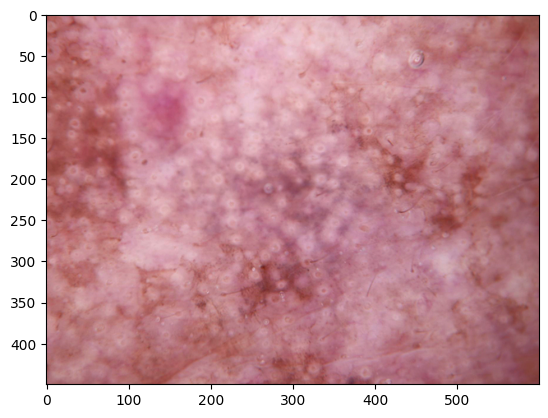

In [9]:
import matplotlib.pyplot as plt

# Loading single image of single calss from dictionary
image = plt.imread(str(list(data_dir_train.glob(class_names[0]+'/*.jpg'))[0]))
plt.imshow(image)

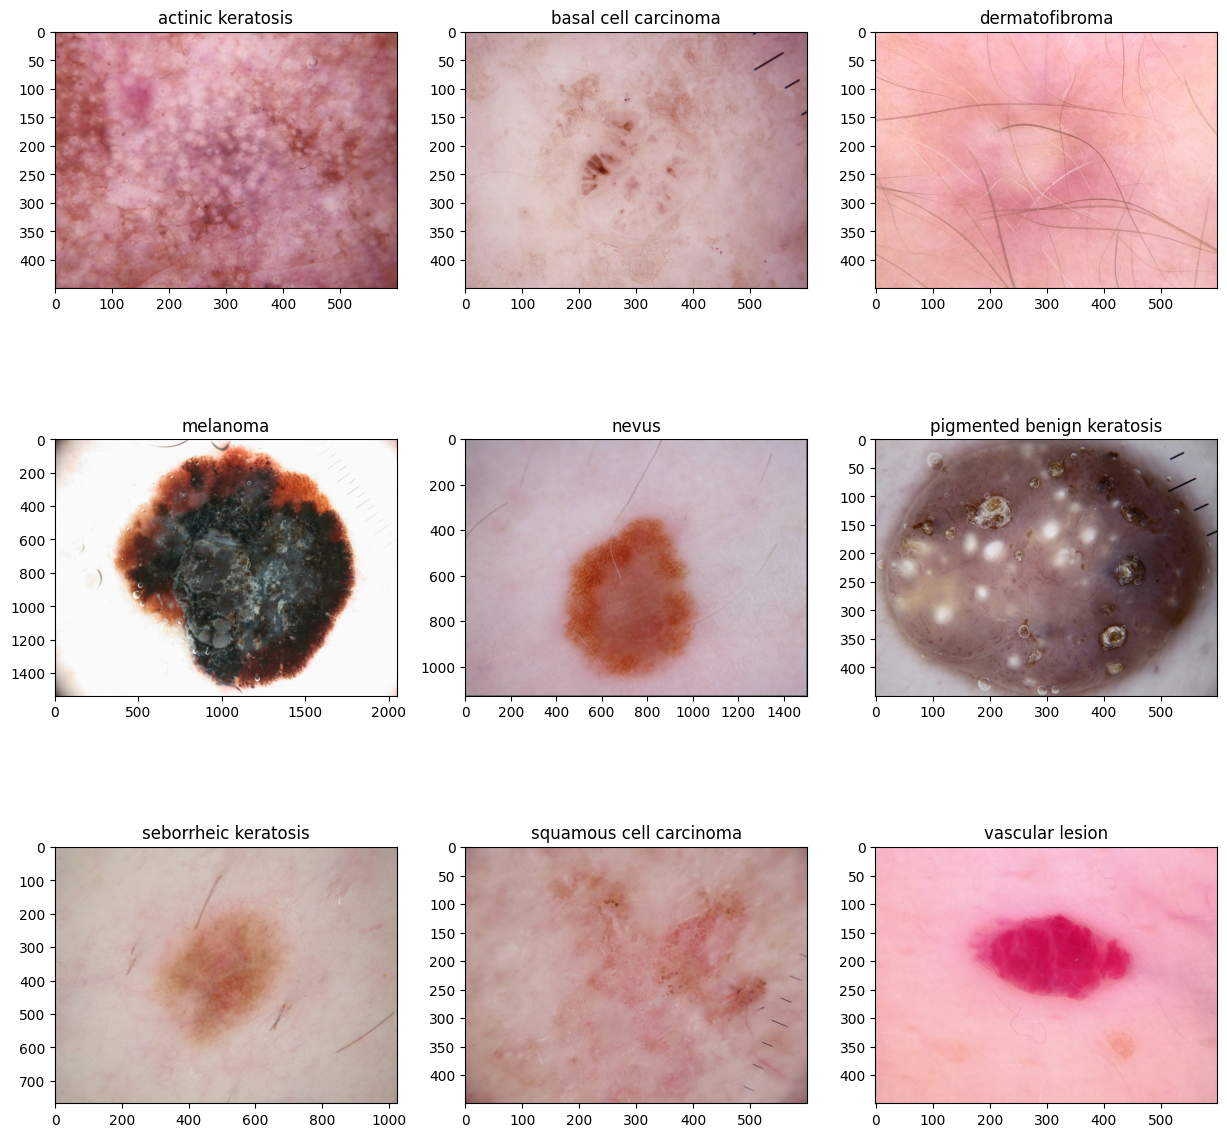

In [10]:
# Loading single image from each class
plt.figure(figsize=(15,15))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[0]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
# Performance tunning

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(len(train_ds)).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)


## 4. Model Building & training

### Create the model

We will create a CNN model using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

We will put this model into a function since we want to check the effects of class imabalance and class distribution in following steps so we should keep the model same through out to check the effects.

In [12]:
def get_model():
    # CNN Model
    model= Sequential()
    # scaling the pixel values from 0-255 to 0-1
    model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

    # Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
    model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
    model.add(layers.MaxPooling2D())

    # Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
    model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
    model.add(layers.MaxPooling2D())

    # Convolution layer with 256 features, 3x3 filter
    model.add(layers.Conv2D(256,(3,3),padding = 'same',activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(9,activation='softmax'))

    return model

### Compile the model
We will Choose an appropirate optimiser and loss function for model training

In [13]:
#Compile the Model
model = get_model()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 256)       2

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 32s 188ms/step - loss: 2.5357 - accuracy: 0.1892 - val_loss: 2.0285 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 4s 79ms/step - loss: 1.9687 - accuracy: 0.2561 - val_loss: 1.8987 - val_accuracy: 0.3065
Epoch 3/20
56/56 [==============================] - 4s 80ms/step - loss: 1.7591 - accuracy: 0.3733 - val_loss: 1.6968 - val_accuracy: 0.4027
Epoch 4/20
56/56 [==============================] - 4s 77ms/step - loss: 1.5982 - accuracy: 0.4392 - val_loss: 1.6068 - val_accuracy: 0.4541
Epoch 5/20
56/56 [==============================] - 4s 75ms/step - loss: 1.5458 - accuracy: 0.4531 - val_loss: 1.6585 - val_accuracy: 0.4497
Epoch 6/20
56/56 [==============================] - 4s 80ms/step - loss: 1.4357 - accuracy: 0.4967 - val_loss: 1.5556 - val_accuracy: 0.4609
Epoch 7/20
56/56 [==============================] - 4s 77ms/step - loss: 1.3653 - accuracy: 0.5212 - val_loss: 1.5712 - val_accuracy: 0.5011
Epoch 8/20


### Visualizing training results

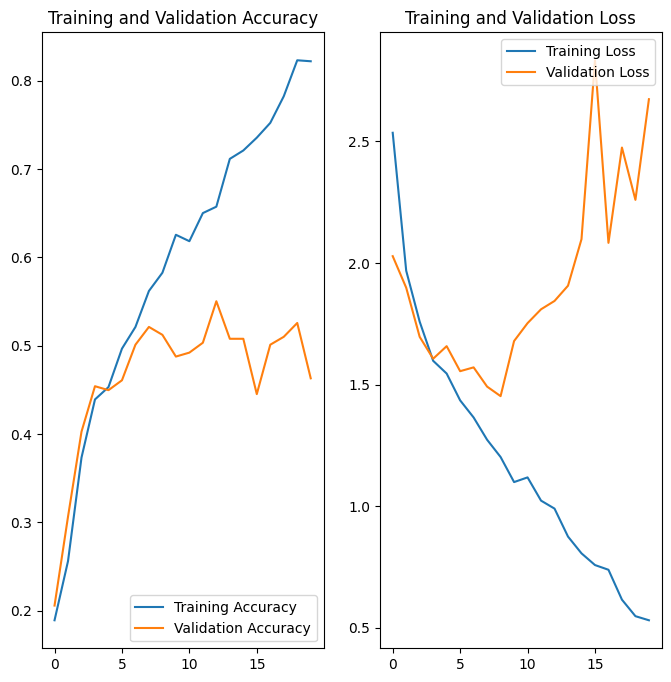

In [16]:
def visualizing_result(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

visualizing_result(history,epochs)

<font color='blue'>**Observation**</font> : <br>
- We can observe that the training accuracy increases linearly over time, but the validation accuracy saturates around 50% while training
- Training loss and validation loss are showing inverse relation
- We can observe **overfiting** of the model as there is significant difference in accuracy of training and validation data set and training accuracy is very high compare to validation accuracy


## 5. Resolve overfitting

We need to fix overfiting by introducing diversity in samples in training data set which will help our model to train on diverse data set and avoid overfiting.

For this we will use augmentation strategy to generate diverse images using our existing data set.

In [17]:
tf.get_logger().setLevel('ERROR')

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1)
  ]
)

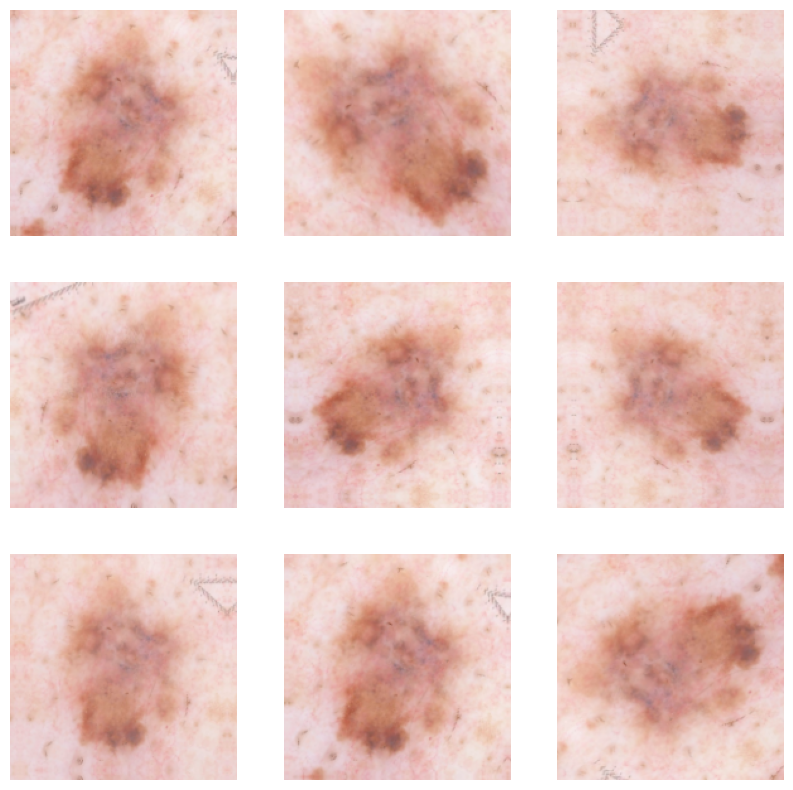

In [19]:
# visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## 6. Model Building & training on the augmented data

### Create the model, compile and train the model


In [20]:
def get_model_with_dropout():
    # CNN Model
    model= Sequential()
    # scaling the pixel values from 0-255 to 0-1
    model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
    model.add(data_augmentation)

    # Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
    model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
    model.add(layers.MaxPooling2D())

    # Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
    model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
    model.add(layers.MaxPooling2D())
    #adding a 20% dropout after the convolution layers
    model.add(layers.Dropout(0.2))

    # Convolution layer with 256 features, 3x3 filter
    model.add(layers.Conv2D(256,(3,3),padding = 'same',activation='relu'))
    #adding a 10% dropout
    model.add(layers.Dropout(0.1))

    model.add(layers.Flatten())
    model.add(layers.Dense(9,activation='softmax'))

    return model

### Compiling the model

In [21]:
#Compile the Model with dropout
model = get_model_with_dropout()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                 

### Training the model

In [22]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 10s 125ms/step - loss: 2.4548 - accuracy: 0.2199 - val_loss: 1.8945 - val_accuracy: 0.3244
Epoch 2/20
56/56 [==============================] - 7s 123ms/step - loss: 1.7039 - accuracy: 0.3761 - val_loss: 1.5477 - val_accuracy: 0.4452
Epoch 3/20
56/56 [==============================] - 7s 127ms/step - loss: 1.6169 - accuracy: 0.4302 - val_loss: 1.5820 - val_accuracy: 0.4676
Epoch 4/20
56/56 [==============================] - 7s 120ms/step - loss: 1.5823 - accuracy: 0.4526 - val_loss: 1.5281 - val_accuracy: 0.4832
Epoch 5/20
56/56 [==============================] - 7s 123ms/step - loss: 1.4882 - accuracy: 0.4738 - val_loss: 1.4949 - val_accuracy: 0.4720
Epoch 6/20
56/56 [==============================] - 7s 126ms/step - loss: 1.4961 - accuracy: 0.4866 - val_loss: 1.4507 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 7s 121ms/step - loss: 1.4503 - accuracy: 0.4883 - val_loss: 1.4686 - val_accuracy: 0.5280
Epoch

### Visualizing the results

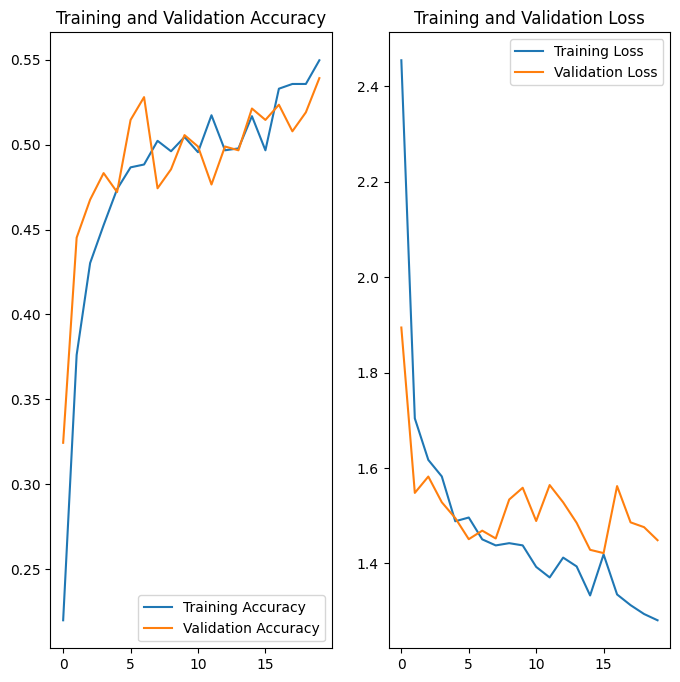

In [23]:
visualizing_result(history,epochs)

<font color='blue'>**Observation**</font> : <br>
- We can observe that the training accuracy increases linearly over time along with validation accuracy and both saturates around 50% while training
- Training loss and validation loss are also dicreasing consistently and almost matching with each other
- We can observe that **overfiting** of the model has **reduced drastically** from previous model results
- However the model is **not very accurate** and the accuracy of the model is around **50-55%**


## 7. Class distribution

#### Find the distribution of classes in the training dataset.
**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
#checking the class distribution in the training dataset
class_diff=pd.DataFrame()
totalFiles = len(list(data_dir_train.glob('*/*.jpg')))
for i in range(len(class_names)):
  name= class_names[i]
  count = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  perc = round(count/totalFiles*100,2)
  class_diff=class_diff.append({'class':name,'images':count,'percentage' : perc},ignore_index=True)
class_diff

,class,images,percentage
0,actinic keratosis,114,5.09
1,basal cell carcinoma,376,16.79
2,dermatofibroma,95,4.24
3,melanoma,438,19.56
4,nevus,357,15.94
5,pigmented benign keratosis,462,20.63
6,seborrheic keratosis,77,3.44
7,squamous cell carcinoma,181,8.08
8,vascular lesion,139,6.21


<Axes: xlabel='class'>

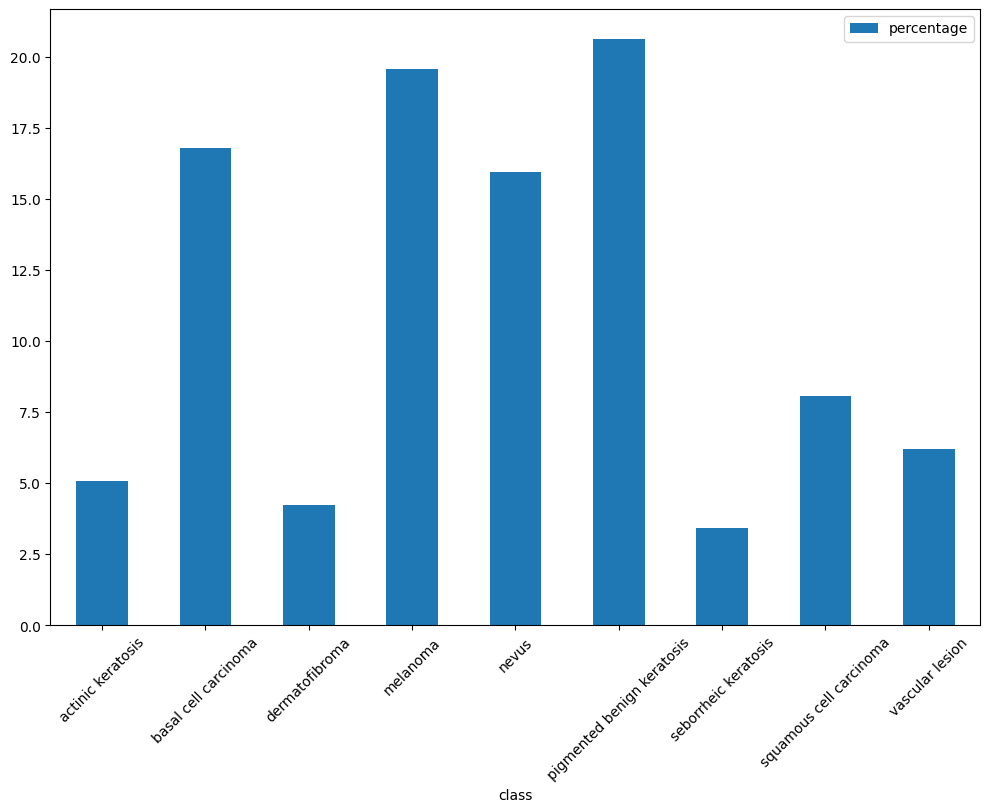

In [25]:
# Plotting class distribution
class_diff.plot.bar(x='class',y='percentage',rot=45,figsize=(12,8))

<font color='blue'>**Observation**</font> : <br>
- **'seborrheic keratosis'** class has the least number of samples
- **'melanoma', 'nevus', 'pigmented benign keratosis'** and **'basal cell carcinoma'** these classes dominate the data in terms proportionate number of samples


## 8. Handling class imbalances

**Context:** We will use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
path_to_training_dataset="//content//drive//MyDrive//Colab//Melanoma_Detection_Assignment_CNN//images//Train//"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to //content//drive//MyDrive//Colab//Melanoma_Detection_Assignment_CNN//images//Train//actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C5FB0043370>: 100%|██████████| 500/500 [00:19<00:00, 25.68 Samples/s]


Initialised with 376 image(s) found.
Output directory set to //content//drive//MyDrive//Colab//Melanoma_Detection_Assignment_CNN//images//Train//basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C5FC78DC760>: 100%|██████████| 500/500 [00:21<00:00, 23.09 Samples/s]


Initialised with 95 image(s) found.
Output directory set to //content//drive//MyDrive//Colab//Melanoma_Detection_Assignment_CNN//images//Train//dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C5FC78DDE40>: 100%|██████████| 500/500 [00:19<00:00, 25.49 Samples/s]


Initialised with 438 image(s) found.
Output directory set to //content//drive//MyDrive//Colab//Melanoma_Detection_Assignment_CNN//images//Train//melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C5FC794C4F0>: 100%|██████████| 500/500 [01:32<00:00,  5.40 Samples/s]


Initialised with 357 image(s) found.
Output directory set to //content//drive//MyDrive//Colab//Melanoma_Detection_Assignment_CNN//images//Train//nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7C5FB00F1750>: 100%|██████████| 500/500 [01:29<00:00,  5.56 Samples/s]


Initialised with 462 image(s) found.
Output directory set to //content//drive//MyDrive//Colab//Melanoma_Detection_Assignment_CNN//images//Train//pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C5FB0596590>: 100%|██████████| 500/500 [00:21<00:00, 23.31 Samples/s]


Initialised with 77 image(s) found.
Output directory set to //content//drive//MyDrive//Colab//Melanoma_Detection_Assignment_CNN//images//Train//seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C5FC78AC490>: 100%|██████████| 500/500 [00:43<00:00, 11.63 Samples/s]


Initialised with 181 image(s) found.
Output directory set to //content//drive//MyDrive//Colab//Melanoma_Detection_Assignment_CNN//images//Train//squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C5FC7973B20>: 100%|██████████| 500/500 [00:21<00:00, 22.95 Samples/s]


Initialised with 139 image(s) found.
Output directory set to //content//drive//MyDrive//Colab//Melanoma_Detection_Assignment_CNN//images//Train//vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C5FB0597040>: 100%|██████████| 500/500 [00:19<00:00, 25.63 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
from glob import glob

In [29]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [31]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [32]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = class_diff.append(df2)

In [33]:
class_diff['new_images'] = class_diff['class'].map(df2['Label'].value_counts())

In [34]:
class_diff['total_images'] = class_diff['images'] + class_diff['new_images']

In [35]:
total_images_count = class_diff.total_images.sum()

In [36]:
class_diff['final_percentage'] = round(class_diff['total_images'] / total_images_count * 100,2)

In [37]:
class_diff

,class,images,percentage,new_images,total_images,final_percentage
0,actinic keratosis,114,5.09,500,614,9.11
1,basal cell carcinoma,376,16.79,500,876,13.00
2,dermatofibroma,95,4.24,500,595,8.83
3,melanoma,438,19.56,500,938,13.92
4,nevus,357,15.94,500,857,12.72
5,pigmented benign keratosis,462,20.63,500,962,14.28
6,seborrheic keratosis,77,3.44,500,577,8.56
7,squamous cell carcinoma,181,8.08,500,681,10.11
8,vascular lesion,139,6.21,500,639,9.48


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## 9. Model Building & training on the rectified class imbalance data

#### Train the model on the data created using Augmentor

In [45]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [46]:
data_dir_train = pathlib.Path('/content/drive/MyDrive/Colab/Melanoma_Detection_Assignment_CNN/images/Train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab/Melanoma_Detection_Assignment_CNN/images/Test')

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=None)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [47]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=None)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [48]:
# Performance tunning

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(len(train_ds)).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

####  Create your model (make sure to include normalization)

In [49]:
#Compile the Model with dropout
model = get_model_with_dropout()

#### Compile your model (Choose optimizer and loss function appropriately)

In [50]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                 

#### Train your model

In [51]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 63s 174ms/step - loss: 2.0210 - accuracy: 0.2522 - val_loss: 1.5686 - val_accuracy: 0.4009
Epoch 2/50
169/169 [==============================] - 20s 121ms/step - loss: 1.6603 - accuracy: 0.3583 - val_loss: 1.7500 - val_accuracy: 0.3222
Epoch 3/50
169/169 [==============================] - 21s 123ms/step - loss: 1.5518 - accuracy: 0.4084 - val_loss: 1.4826 - val_accuracy: 0.4254
Epoch 4/50
169/169 [==============================] - 21s 121ms/step - loss: 1.4990 - accuracy: 0.4227 - val_loss: 1.4284 - val_accuracy: 0.4662
Epoch 5/50
169/169 [==============================] - 20s 120ms/step - loss: 1.4782 - accuracy: 0.4360 - val_loss: 1.3988 - val_accuracy: 0.4870
Epoch 6/50
169/169 [==============================] - 20s 119ms/step - loss: 1.4240 - accuracy: 0.4464 - val_loss: 1.3637 - val_accuracy: 0.4892
Epoch 7/50
169/169 [==============================] - 20s 121ms/step - loss: 1.4581 - accuracy: 0.4436 - val_loss: 1.3919 - val_ac

#### Visualize the model results

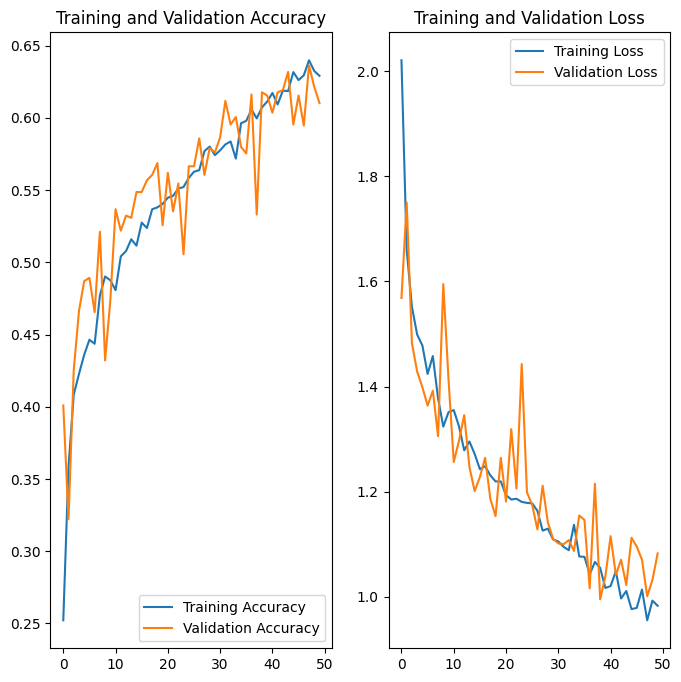

In [52]:
visualizing_result(history,epochs)

## 10. Conclusion

*   We can observe that training accuracy and validation accuracy is almost similar indiciating good fit. Hence our underfiting and overfiting issue is resolved
*   Training loss and validation loss are also almost similar indicating good  model fit
*   Class rebalance definately helped as we can see the accuracy of model has increased drastically using the same model. The model is now able to handle minoirity classes better compare to earlier model and over all accuracy of the model is around **65%**
*   We can further improve the performance of the model by tweaking the model

